# Step 1: Import lib

In [131]:
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch as torch # core lib for deep learning methods
import time as time   # maybe I will use time to test how long a piece of code takes
import numpy as np    # it's likely that we use numpy to perform matrix manipulation
import cv2 as cv      # image I/O
import os as os

# Step 2: Build custom class for the dataset
* ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
* Custom Dataset needs at least the following 3 methods:
    1. `__init__`: This function is run once when instantiating the Dataset object.
    2. `__len__`: This function returns the number of samples in our dataset.
        * At least, dataloader will need to call this function.
    3. `__getitem__`: This function loads and returns a sample from the dataset at the given index (i.e., `idx`).

In [132]:
from torch.utils.data import Dataset

class CAT_DOG_DATASET(Dataset):
    
    def __init__(self, img_dir, img_size, x_transform=None, y_transform=None):
        
        self.img_dir = img_dir
        self.img_size = img_size
        self.x_transform = x_transform
        self.y_transform = y_transform
        
        self.imgs = os.listdir(self.img_dir)
        self.len = len(self.imgs)
        self.ans_list = list()
        self.img_path_list = list()
        self.__loop_through_dir__()

    def __len__(self):
        return self.len
    
    def __getitem__(self, idx):
        
        # input: image
        img_path = self.img_path_list[idx]
        image = self.__preprocess__(img_path)
#         image = cv.imread(img_path)
#         image = cv.resize(image, (img_size, img_size))
#         image = image / 255.
#         if self.x_transform:
#             image = self.x_transform(image)
        
#         image = image.reshape(3, img_size, img_size)
        
        # output: label
        label = self.ans_list[idx]
        if self.y_transform:
            label = self.y_transform(label)
        
        return image, label
    
    def __preprocess__(self, img_path):
        
        image = cv.imread(img_path)
        image = cv.resize(image, (img_size, img_size))
        image = image / 255.
        
        # channel first
        if self.x_transform:
            image = self.x_transform(image)
        
        image = image.reshape(3, img_size, img_size)
        return image
    
    def __loop_through_dir__(self):

        for img_name in tqdm(self.imgs):

            img_path = self.img_dir + img_name
            self.img_path_list.append(img_path)

            ans = img_name.split(".")[0]
            if ans == "cat":
                self.ans_list.append(0)
            else: # ans == "dog"
                self.ans_list.append(1)


# Step 3: Hyperparamter setting

In [133]:
learning_rate = 1e-4
batch_size = 128
epochs = 30
model_path = './model/CNN_model_weights.pth'
train_dir_path = "../../Dataset/Cat_and_Dog/train/train/"
img_size = 128

# Step 4: Setup dataloader

In [134]:
from torch.utils.data import DataLoader

tran_dataset = CAT_DOG_DATASET(img_dir=train_dir_path, img_size=img_size)
tran_loader = DataLoader(tran_dataset, batch_size=batch_size, shuffle=True)

100%|██████████████████████████████████████████████| 25000/25000 [00:00<00:00, 1469870.20it/s]


# Step 5: Get device for training
* ref: https://pytorch.org/tutorials/beginner/basics/buildmodel_tutorial.html

In [135]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cpu device


# Step 6: Define the class (for model)
* `nn.Conv2d`: https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
* `nn.Linear`: https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear
* [calculator](https://madebyollin.github.io/convnet-calculator/) for `width`, `height`, `channels`, `stride`, `padding`

In [136]:
from torch import nn

class CNN_v1(nn.Module):
    
    def __init__(self, img_size): # I add one more param here, i.e., img_size, for changing CNN structure auto
        super(CNN_v1, self).__init__()
        
        self.img_size = img_size # assume (B, C=3, H=256, W=256)
        
        self.cspec = [3, 64, 128, 256, 512, 1024, 512, 256] # cspec stands for conv spec
        self.fspec = [128, 64, 1] # fspec stands for fully connected layer spec

        self.repeat_conv = nn.Sequential(

            # 換換不同的寫法 v1
            nn.Conv2d(
                in_channels = self.cspec[0],
                out_channels = self.cspec[1],
                kernel_size = (3, 3), # this could be tuple, i.e., (3,3), or just integer i.e., 3.
                stride = 2, # based on the calculator mentioned above, this setting will make spatial size half
                padding = 1 
            ),
            nn.ReLU(),                   # (B, C=  64, H=128, W=128)
            nn.BatchNorm2d(self.cspec[1]),
            #nn.MaxPool2d(kernel_size=2), # (B, C=  64, H= 64, W= 64)

            # 換換不同的寫法 v2
            nn.Conv2d(in_channels=self.cspec[1], out_channels=self.cspec[2], kernel_size=(3, 3), stride=2, padding=1), 
            nn.ReLU(),                   # (B, C= 128, H= 64, W= 64)
            nn.BatchNorm2d(self.cspec[2]),
            #nn.MaxPool2d(kernel_size=2), # (B, C= 128, H= 32, W= 32)
            
            nn.Conv2d(in_channels=self.cspec[2], out_channels=self.cspec[3], kernel_size=(3, 3), stride=2, padding=1), 
            nn.ReLU(),                   # (B, C= 256, H= 32, W= 32)
            nn.BatchNorm2d(self.cspec[3]),
            #nn.MaxPool2d(kernel_size=2), # (B, C= 256, H= 16, W= 16)
            
            nn.Conv2d(in_channels=self.cspec[3], out_channels=self.cspec[4], kernel_size=(3, 3), stride=2, padding=1), 
            nn.ReLU(),                   # (B, C= 512, H= 16, W= 16)
            nn.BatchNorm2d(self.cspec[4]),
            #nn.MaxPool2d(kernel_size=2), # (B, C= 512, H=  8, W=  8)
            
            nn.Conv2d(in_channels=self.cspec[4], out_channels=self.cspec[5], kernel_size=(3, 3), stride=2, padding=1), 
            nn.ReLU(),                   # (B, C=1024, H=  8, W=  8)
            nn.BatchNorm2d(self.cspec[5]),
            #nn.MaxPool2d(kernel_size=2), # (B, C=1024, H=  4, W=  4)
        
            nn.Conv2d(in_channels=self.cspec[5], out_channels=self.cspec[6], kernel_size=(3, 3), stride=2, padding=1), 
            nn.ReLU(),                   # (B, C= 512, H=  4, W=  4)
            nn.BatchNorm2d(self.cspec[6]),
            #nn.MaxPool2d(kernel_size=2), # (B, C= 512, H=  2, W=  2)
            
            nn.Conv2d(in_channels=self.cspec[6], out_channels=self.cspec[7], kernel_size=(3, 3), stride=2, padding=1), 
            nn.ReLU(),                   # (B, C= 256, H=  2, W=  2)
            nn.BatchNorm2d(self.cspec[7]),
            #nn.MaxPool2d(kernel_size=2), # (B, C= 256, H=  1, W=  1)
        )

        self.flatten = nn.Flatten()

        # 需要優化 #
        C = 256
        H = 1
        W = H # assume square
        self.repeat_dense = nn.Sequential(
            nn.Linear(in_features= C*H*W, out_features=self.fspec[0]),
            nn.ReLU(),
            nn.Linear(in_features= self.fspec[0], out_features=self.fspec[1]),
            nn.ReLU(),
            nn.Linear(in_features= self.fspec[1], out_features=self.fspec[2]),
            nn.ReLU()
        )
                    
    def forward(self, img):
        feature_map = self.repeat_conv(img)
        features = self.flatten(feature_map)
        logits = self.repeat_dense(features)
        return logits
    
def test():
    batch_size = 10
    channel_num = 3
    img_size = 128

    CNN_model = CNN_v1(img_size=img_size)
    
    # Usually use torch.randn to test if model can work as expected
    input_img = torch.randn(batch_size, channel_num, img_size, img_size) # (batch_size, channel, width, height)
    
    output_val= CNN_model(input_img)
    
    assert output_val.detach().numpy().shape == (batch_size, 1)
    
test()

# Step 7: Loss function
* `BCELoss`: https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html

In [137]:
# binary cross entropy loss
bce_loss = torch.nn.BCEWithLogitsLoss()
#bce_loss = torch.nn.BCELoss()

# Step 8: Setup Model

In [138]:
CNN_model = CNN_v1(img_size=img_size).to(device)
print(CNN_model)

CNN_v1(
  (repeat_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(1024, 512, kernel_size=(3, 3)

# Step 9: Choose optimizer

In [139]:
adam_optimizer = torch.optim.Adam(CNN_model.parameters(), lr=learning_rate)

# Step 10: Optimization process
* ref: https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
* ref2: https://discuss.pytorch.org/t/expected-object-of-scalar-type-double-but-got-scalar-type-float-for-argument-3-mat1-in-call-to-th-addmm/109332
* ref3: https://stackoverflow.com/questions/57798033/valueerror-target-size-torch-size16-must-be-the-same-as-input-size-torch

In [140]:
def train_loop(dataloader, model, loss_fn, optimizer):
    
    size = len(dataloader.dataset)
    loss_list = list()
    
    for batch, (X, y) in tqdm(enumerate(dataloader)):
        X = X.to(device)
        y = y.to(device)
        
        # derive prediction
        pred = model(X.float()) # Wondering about X.float()? check ref2
        loss = loss_fn(pred, y.float().unsqueeze(1)) # Wondering about unsqueeze(1)? Check ref3
        
        # backward propagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch % 10 == 0:
            loss, current = loss.item(), batch * len(X)
            loss_list.append(loss)
            print(f"loss: {loss:>7f} [{current:>5d}/{size:>5d}]")
            
    return loss_list

In [141]:
for t in range(epochs):
    print(f"Epoch {t+1}\n----------------------------")
    train_loop(tran_loader, CNN_model, bce_loss, adam_optimizer)
print("Done")

Epoch 1
----------------------------


1it [00:03,  3.76s/it]

loss: 0.692581 [    0/25000]


11it [00:42,  3.85s/it]

loss: 0.693329 [ 1280/25000]


21it [01:22,  3.82s/it]

loss: 0.684641 [ 2560/25000]


30it [02:02,  4.07s/it]


KeyboardInterrupt: 

# Step 11: Save model
* ref: https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [59]:
torch.save(CNN_model.state_dict(), model_path)

# Step 12: Load model
* ref: https://pytorch.org/tutorials/beginner/basics/saveloadrun_tutorial.html

In [111]:
CNN_model = CNN_v1(img_size=img_size).to(device)
CNN_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
CNN_model.eval()

CNN_v1(
  (repeat_conv): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU()
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (7): ReLU()
    (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (10): ReLU()
    (11): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Conv2d(512, 1024, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (13): ReLU()
    (14): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Conv2d(1024, 512, kernel_size=(3, 3)

# Step 13: Test Imgs

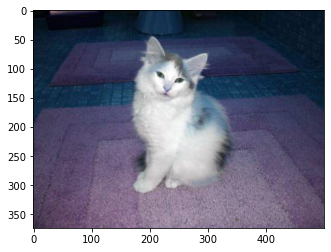

tensor([[0.5000]], grad_fn=<SigmoidBackward0>)

In [130]:
test_dir_path = "../../Dataset/Cat_and_Dog/test/test1/"

# pick one image / or directly name this filename
chosen_index = 1

# use custom path
test_img_path = test_dir_path+os.listdir(test_dir_path)[chosen_index]

# plot the image
test_img = cv.imread(test_img_path)
plt.imshow(test_img)
plt.show()

# preprocess the image
test_img_numpy = tran_dataset.__preprocess__(test_img_path)

#  convert data type from numpy to tensor
test_img_tensor = torch.tensor(test_img_numpy).to(device)

# add the dim as the batch
test_img_tensor = torch.unsqueeze(test_img_tensor, 0).float()

with torch.no_grad():
    pred_probability = CNN_model(test_img_tensor)
    if pred_probability > 0.5:
        result = {"result": "dog"}
    else:
        result = {"result": "cat"}
    
    print(result)